In [5]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
#2. Import dataset
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [9]:
#3. Check image shape
X_train[0].shape

(28, 28)

In [10]:
#4. Data pre-processing

# reshape data to fit the model
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Inspect what the one-hot encoding looks like for the first value
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [11]:
# 5. Create the model with CNN layers
# More information: https://keras.io/api/layers/convolution_layers/convolution2d/

from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()

# add a conv layer with "same" zero padding
model.add(Conv2D(64, kernel_size = 3, activation = 'relu', padding = "SAME", input_shape = (28, 28, 1)))

# Add a pooling layer
model.add(MaxPooling2D(pool_size= (2,2)))

# Add a second conv layer with a stride of 2x2
model.add(Conv2D(32, kernel_size = 3, activation = "relu", padding = "SAME", strides = (2,2)))

# Add a pooling layer
model.add(MaxPooling2D(pool_size = (2,2)))

# Flatten the input
model.add(Flatten())

# Regular FC layer with output size 10 (for the 10 digits)
model.add(Dense(10, activation = "softmax"))

# Print the summary of the model to view the shape and number of parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 32)          18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                2890      
Total params: 21,994
Trainable params: 21,994
Non-trainable params: 0
____________________________________________________

2022-02-12 19:44:26.334973: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-12 19:44:26.335108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 19:44:26.335372: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2022-02-12 19:44:26.335394: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-12 19:44:26.335412: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-12 19:44:26.335423: I tensorflow/stream_executor/platfor

In [12]:
# 6. Specify the optimizer
model.compile(optimizer = 'SGD', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [13]:
#7. Time how fast the model train

import time

start = time.time()

# Train using a minibatch stochastic gradient descence
history = model.fit(X_train, y_train, batch_size = 64, epochs = 2, verbose = 1)

end = time.time()

num_mins = (end-start)/60
print("Total training time: "  + str(num_mins) + " minutes.")

2022-02-12 19:46:27.270699: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-12 19:46:27.290578: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/2


2022-02-12 19:46:27.548426: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-12 19:46:27.966435: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-02-12 19:46:28.811376: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-02-12 19:46:28.837151: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


938/938 [==============================] - 10s 7ms/step - loss: 12.1943 - accuracy: 0.4786
Epoch 2/2
938/938 [==============================] - 6s 6ms/step - loss: 0.7475 - accuracy: 0.7619
Total training time: 0.2590240240097046 minutes.


In [14]:
#8. Evaluate the model 

score = model.evaluate(X_test, y_test, verbose = 0)
print("Test loss: %.4f" % score[0])
print("Test accuracy: %.2f" % (score[1] * 100.0))

Test loss: 0.6806
Test accuracy: 78.18


In [23]:
#9. K-fold cross validation
from sklearn.model_selection import KFold
n_folds = 5
scores = []
histories = []

# prepare cross validation
kfold = KFold(n_folds, shuffle = True, random_state = 1)

# enumerate splits
for train_i, test_i in kfold.split(X_train):
    #select the rows for train and test
    trainX, trainY, testX, testY = X_train[train_i], y_train[train_i], X_train[test_i], y_train[test_i]
    #fit model with the new train subset
    history = model.fit(trainX, trainY, epochs = 8, batch_size = 32, validation_data= (testX, testY))
    #evaluate the model with the new test subset
    loss, acc = model.evaluate(testX, testY, verbose =0)
    print("%.2f" % (acc * 100.0))
    scores.append(acc)
    histories.append(history)

Epoch 1/8
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0726 - accuracy: 0.9760 - val_loss: 0.0762 - val_accuracy: 0.9760
Epoch 2/8
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0689 - accuracy: 0.9776 - val_loss: 0.0997 - val_accuracy: 0.9693
Epoch 3/8
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0672 - accuracy: 0.9786 - val_loss: 0.0779 - val_accuracy: 0.9770
Epoch 4/8
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0664 - accuracy: 0.9780 - val_loss: 0.0817 - val_accuracy: 0.9762
Epoch 5/8
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0644 - accuracy: 0.9792 - val_loss: 0.0787 - val_accuracy: 0.9768
Epoch 6/8
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0628 - accuracy: 0.9795 - val_loss: 0.0841 - val_accuracy: 0.9768
Epoch 7/8
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0628 - accuracy: 0.9797 - val_loss: 0.1124 - val_accuracy: 0.9662

In [24]:
len(histories)

5

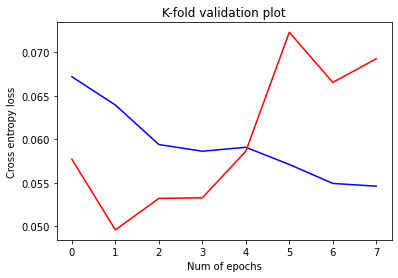

In [26]:
#10. Plot loss function

from matplotlib import pyplot as plt

plt.plot(histories[3].history["loss"], color = "blue", label = "train")
plt.plot(histories[3].history["val_loss"], color = "red", label = "test")

plt.title("K-fold validation plot")
plt.ylabel("Cross entropy loss")
plt.xlabel("Num of epochs")
plt.show()